<a href="https://colab.research.google.com/github/zia207/python-colab/blob/main/NoteBook/Machine_Learning/Tree_based/03-01-02-07-tree-based-models-bagging-random-survival-forest-python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](http://drive.google.com/uc?export=view&id=1IFEWet-Aw4DhkkVe1xv_2YYqlvRe9m5_)

# 2.7 Random Survival Forest

Random Survival Forests are a powerful extension of Random Forests designed for survival analysis, which deals with time-to-event data. They are particularly useful in fields like medicine, engineering, and finance, where understanding the timing of events is crucial. In this section, we will explore the concept of Survival Forests, their advantages, limitations, and applications.

## Overview

A **Survival Forest**, often referred to as a **Random Survival Forest (RSF)**, is a machine learning model used for survival analysis. It extends the concept of Random Forests to handle time-to-event data, where the outcome of interest is the time until an event occurs (e.g., death, disease recurrence, or equipment failure). Survival Forests are particularly useful for modeling censored data, where the event of interest may not be observed for all subjects during the study period.




### Key Concepts

-   `Survival Analysis`: Focuses on modeling the time until an event occurs. It accounts for **censoring**, where the event hasn't occurred for some subjects by the end of the observation period or they are lost to follow-up.
-   `Random Forest`: A collection of decision trees that make predictions by averaging or voting across many trees, reducing overfitting and improving robustness.
-   `Survival Forest`: Adapts Random Forests to predict survival outcomes, such as the probability of surviving past a certain time or the risk of an event occurring.

### How Survival Forests Work

Survival Forests combine the principles of Random Forests with survival analysis. Here’s a step-by-step explanation:

1. Understand the Data

Survival data consists of: - **Features**: $X = (X_1, X_2, \dots, X_p)$, a vector of predictors (e.g., age, blood pressure, treatment type).

- Event Time: $T$, the time to the event (or censoring time if the event doesn’t occur).

- Censoring Indicator: $\delta$, where $\delta = 1$ if the event is observed, and $\delta = 0$ if the observation is censored (e.g., patient lost to follow-up).

- Dataset: $\{(X_i, T_i, \delta_i)\}_{i=1}^n$, for $n$ observations.

- Estimate the survival function $S(t) = P(T > t)$, the probability of surviving past time $t$, or the cumulative hazard function $H(t) = \int_0^t h(u) \, du$, where $h(t)$ is the hazard rate.

2. Bootstrap Sampling

Survival Forests use the Random Forest principle of ensemble learning: - **Draw Bootstrap Samples**: For each of $B$ trees, randomly sample $n$ observations **with replacement** from the dataset. This creates a bootstrap sample $D_b = \{(X_i, T_i, \delta_i)\}_{i \in S_b}$, where $S_b$ is the set of indices for tree ( b ).

- Out-of-Bag (OOB) Data: Observations not included in the bootstrap sample for a tree are used for validation or error estimation.

3. Build Survival Trees

Each tree is constructed as follows:

-   Start at the Root Node:

  -   The root contains the bootstrap sample $D_b$.
   
  -   Select a random subset of features (e.g., $m = \sqrt{p}$ features, where $p$ is the total number of features).
    
-   Node Splitting:

  -   For each node, evaluate possible splits on the selected features.

  -   A split divides the node into two child nodes based on a feature $X_j$ and threshold $s$, e.g., $X \leq s$ (left child) and $X_j > s$ (right child).

    -   Choose the split that maximizes a survival-specific criterion, typically the **log-rank statistic**, which tests whether survival distributions differ between the two groups.

    -   Log-Rank Statistic:

    -   For a split at time $t$, let:

        -   $d_{i1}$: Number of events in the left child at time $t_i$.
        -   $n_{i1}$: Number of individuals at risk in the left child just before $t_i$.
        -   $d_i$: Total events at $t_i$ in the parent node.
        -   $n_i$: Total individuals at risk in the parent node.

    -   Expected events in the left child under the null hypothesis (no difference in survival):

$$ e_{i1} = \frac{n_{i1}}{n_i} \cdot d_i $$

  -   The log-rank statistic is:

$$ \chi^2 = \sum_{t_i} \frac{(d_{i1} - e_{i1})^2}{\text{Var}(d_{i1} - e_{i1})} $$

   where the variance is approximated as:

$$  \text{Var}(d_{i1} - e_{i1}) \approx \frac{n_{i1} \cdot (n_i - n_{i1}) \cdot d_i \cdot (n_i - d_i)}{n_i^2 \cdot (n_i - 1)} $$

   -   Choose the split (feature $X_j$, threshold $s$ that maximizes $\chi^2$.

    -   Grow the Tree:

    -   Recursively apply the splitting process to each child node until a stopping criterion is met (e.g., minimum node size, maximum depth, or insufficient events).

    -   Each leaf node contains a subset of observations.

    -   Leaf Node Estimation:

    -   For each leaf node, compute the **Nelson-Aalen estimator** for the cumulative hazard function (CHF) using the observations in that leaf:

$$ \hat{H}(t) = \sum_{t_i \leq t} \frac{d_i}{n_i} $$

        where:

   -   $t_i$: Distinct event times in the leaf.
   -   $d_i$: Number of events ($\delta_i = 1$) at time $t_i$.
   -   $n_i$: Number of individuals at risk just before $t_i$ (those with $T_i \geq t_i$).

    -   The survival function for the leaf is:

$$  \hat{S}(t) = e^{-\hat{H}(t)} $$

4. Aggregate Trees

For each observation $X$, the Survival Forest aggregates predictions across all $B$ trees: - Pass $X$ through each tree $b = 1, \dots, B$ to find the leaf node it belongs to.

- Retrieve the CHF $\hat{H}_b(t)$ from the leaf node of tree $b$.

- Compute the ensemble CHF by averaging:

$$ \hat{H}(t) = \frac{1}{B} \sum_{b=1}^B \hat{H}_b(t) $$

-   The ensemble survival function is:

$$ \hat{S}(t) = e^{-\hat{H}(t)} $$

Alternatively, some implementations average survival functions directly or use other aggregation methods, but the CHF is most common due to its stability.

5. Handling Censoring

Censoring is a key challenge in survival analysis. Survival Forests handle it by: - Including both censored ($\delta = 0$) and uncensored ($\delta = 1$) observations in the "at-risk" set $n_i$ until their event or censoring time.

- Only uncensored events contribute to $d_i$ in the Nelson-Aalen estimator.

- The log-rank statistic accounts for censoring by considering the expected number of events under the null hypothesis, adjusted for the at-risk population.

6. Prediction for New Data

For a new observation with features $X_{\text{new}}$:

-   Pass $X_{\text{new}}$ through each of the $B$ trees to find the corresponding leaf node.

-   Retrieve the CHF $\hat{H}_b(t)$ from each tree’s leaf.

-   Compute the ensemble CHF:

$$  \hat{H}(t) = \frac{1}{B} \sum_{b=1}^B \hat{H}_b(t) $$

-   Compute the survival function:

$$ \hat{S}(t) = e^{-\hat{H}(t)} $$

-   Optionally, compute the hazard function $h(t)$ by taking the derivative of $H(t)$, though this is less common in practice.

Below is a simplified flowchart illustrating the end-to-end process of building and using a Random Survival Forest:


![alt text](http://drive.google.com/uc?export=view&id=1IBAWOR23eSJShSzMm0_VErS-wEpMslDW)


### Advantages and Limitations

**Advantages**:

-   `Non-parametric`: Does not assume a specific distribution for survival times (unlike traditional models like Cox regression).
-   `Handles Complex Relationships`: Captures non-linear relationships and interactions between features without needing explicit specification.
-   `Robust to Overfitting`: Randomization in tree construction (bootstrapping and feature subsampling) reduces overfitting.
-   `Feature Importance`: Can rank the importance of predictors in influencing survival outcomes.

**Limitations**:

-   `Computationally Intensive`: Building many trees with survival-specific criteria can be slow for large datasets.
-   `Interpretability`: Like Random Forests, Survival Forests are less interpretable than simpler models like Cox regression.
-   `Tuning Required`: Parameters like the number of trees, depth, or feature subsampling need careful tuning for optimal performance.





### Applications

-   `Medical Research`: Predicting patient survival or time to disease recurrence based on clinical and demographic features.
-   `Reliability Engineering`: Estimating time to failure for mechanical systems.
-   `Finance`: Modeling time to default on loans or other financial events.



## Random Survival Forest from Scratch

In this section, we will implement a Random Survival Forest from scratch in Python. Below is a step-by-step implementation of the Random Survival Forest algorithm, including data preparation, tree construction, and prediction.

### Load and preprocess the Melanoma dataset

In [12]:
import pandas as pd
import numpy as np

### Load and preprocess the Melanoma dataset

# Use the raw data URL from GitHub
data = pd.read_csv("https://raw.githubusercontent.com/zia207/r-colab/main/Data/Machine_Learning/Melanoma.csv")


# 3. Convert the 'time' column from days to years by dividing by 365.
data['time'] = data['time'] / 365

# 4. Recode the 'status' column so that 1 represents the event (death due to melanoma) and 0 represents censoring (alive or died from other causes).
# R status: 1=died from melanoma, 2=alive, 3=died from other causes
# Target Python status: 1=event (died from melanoma), 0=censored (alive or died from other causes)
data['status'] = data['status'].apply(lambda x: 1 if x == 1 else 0)

# 5. Select only the relevant columns (already done during DataFrame creation for this example,
# but explicitly selecting to match the R code structure).
data = data[['time', 'status', 'age', 'sex', 'thickness', 'ulcer']]

# 6. Remove any rows containing missing values in the selected columns.
data = data.dropna()

# 7. Store the resulting DataFrame in a variable named `data`. (Already done)

# Display the first few rows of the processed data
display(data.head())

,time,status,age,sex,thickness,ulcer
0,0.000075,0,76,1,6.76,1
1,0.000225,0,56,1,0.65,0
2,0.000263,0,41,1,1.34,0
3,0.000743,0,71,0,2.90,0
4,0.001389,1,52,1,12.08,1



### Function to perform bootstrap sample

`bootstrap_sample()` function generates a bootstrap sample from the dataset, ensuring that the sample has at least one non-NA time and one event. If the sample is invalid (e.g., all times are NA or no events), it resamples until a valid sample is obtained.

In [13]:
def bootstrap_sample(data, n):
    """Generates a bootstrap sample from the data, ensuring validity."""
    while True:
        # Generate random indices with replacement
        indices = np.random.choice(data.index, size=n, replace=True)
        sample_data = data.loc[indices].reset_index(drop=True)

        # Check for validity:
        # 1. Not all 'time' values are NA
        # 2. Sample is not empty
        # 3. Contains at least one event (status == 1)
        if (not sample_data['time'].isnull().all() and
                not sample_data.empty and
                (sample_data['status'] == 1).any()):
            return sample_data

### Log-rank test for splitting

The log-rank test for splitting is a statistical method used to compare survival distributions between two groups, often in survival analysis or decision trees for survival data. It evaluates whether a split (based on a variable and threshold) creates two groups with significantly different survival times. The test is commonly used to select optimal splits in survival trees by maximizing the difference in survival curves.

`log_rank_test()` function calculates the log-rank test statistic for a given split in survival data.  In survival trees, this function evaluates potential splits by computing the log-rank statistic for each candidate split (variable and threshold). The split with the highest statistic is chosen, as it maximizes the survival difference between resulting groups.

In [14]:
import numpy as np
import pandas as pd

def log_rank_test(time, status, split_var, split_point, is_categorical=False):
    """
    Calculates the log-rank test statistic for a given split.

    Args:
        time (pd.Series): Series of time to event or censoring.
        status (pd.Series): Series indicating event (1) or censoring (0).
        split_var (pd.Series): Series containing the variable to split on.
        split_point (float or str): The threshold or category for the split.
        is_categorical (bool): True if split_var is categorical, False otherwise.

    Returns:
        float: The log-rank test statistic, or -inf if calculation is not meaningful.
    """
    # Combine data for easier handling of NAs
    temp_df = pd.DataFrame({'time': time, 'status': status, 'split_var': split_var})
    temp_df = temp_df.dropna() # Remove rows with NA in relevant columns

    if temp_df.empty or temp_df['status'].sum() == 0:
        return -np.inf # Cannot compute log-rank if no data or no events

    # Split data into two groups
    if is_categorical:
        group1_mask = temp_df['split_var'] == split_point
    else:
        group1_mask = temp_df['split_var'] <= split_point

    group1_df = temp_df[group1_mask]
    group2_df = temp_df[~group1_mask]

    # Ensure both groups have data and at least one event in total for meaningful split
    if group1_df.empty or group2_df.empty or (group1_df['status'].sum() + group2_df['status'].sum() == 0):
         return -np.inf

    # Get unique event times from combined data
    event_times = np.sort(temp_df[temp_df['status'] == 1]['time'].unique())

    stat = 0
    for t in event_times:
        # Individuals at risk just before time t
        at_risk1 = (group1_df['time'] >= t).sum()
        at_risk2 = (group2_df['time'] >= t).sum()
        total_at_risk = at_risk1 + at_risk2

        # Events at time t
        events1 = ((group1_df['time'] == t) & (group1_df['status'] == 1)).sum()
        events2 = ((group2_df['time'] == t) & (group2_df['status'] == 1)).sum()
        total_events = events1 + events2

        if total_at_risk > 0:
            # Expected events in group 1 under the null hypothesis
            expected1 = at_risk1 * total_events / total_at_risk

            # Variance approximation
            if total_at_risk > 1 and total_events > 0 and total_at_risk - total_events > 0:
                variance = (at_risk1 * at_risk2 * total_events * (total_at_risk - total_events)) / \
                           (total_at_risk**2 * (total_at_risk - 1))
                # Add to statistic if variance is not zero
                if variance > 1e-9: # Use a small epsilon to avoid division by near zero
                     stat += (events1 - expected1)**2 / variance
            # Handle cases where variance is 0 or undefined
            elif events1 - expected1 != 0:
                 # If variance is zero but there is a difference, this is an infinite statistic
                 return np.inf # Indicate perfect separation if expected is 0 but observed isn't or vice versa with zero variance
        # If total_at_risk is 0, no one is at risk at this time point across both groups, skip

    # Handle cases where no event times were processed meaningfully
    if not np.isfinite(stat) or stat < 0: # Log-rank stat should be non-negative, if it's not or inf, indicates a problem
         return -np.inf

    return stat

### Build a single survival tree

The `build_survival_tree()` function constructs a single survival tree for survival data, recursively splitting data to maximize survival differences using the log-rank test. It predicts cumulative hazard functions (CHFs) at leaf nodes.

In [15]:
import numpy as np
import pandas as pd

def build_survival_tree(data, max_depth, min_node_size, depth=0):
    """
    Builds a single survival tree.

    Args:
        data (pd.DataFrame): The dataset for the current node.
        max_depth (int): Maximum depth of the tree.
        min_node_size (int): Minimum number of observations in a node to split.
        depth (int): Current depth of the tree.

    Returns:
        dict: A dictionary representing the node or leaf, containing split information
              or CHF estimates.
    """
    # Filter out rows with NA in time or status early
    data = data.dropna(subset=['time', 'status'])

    # Stop criteria: max depth, too few observations, no events, or no valid data
    if depth >= max_depth or len(data) < min_node_size or data['status'].sum() == 0:
        # Leaf node: Calculate Nelson-Aalen CHF
        times = np.sort(data[data['status'] == 1]['time'].unique())
        if len(times) == 0:
            # If no events, define a trivial CHF
            max_time = data['time'].max() if not data['time'].empty and data['time'].max() is not np.nan else 10
            times = np.linspace(0, max_time + 1e-9, 2) # Ensure at least two points, add small epsilon
            chf = np.array([0.0, 0.0])
        else:
            chf_values = []
            for t in times:
                d_i = ((data['time'] == t) & (data['status'] == 1)).sum()
                n_i = (data['time'] >= t).sum()
                chf_values.append(d_i / n_i if n_i > 0 else 0)
            chf = np.cumsum(chf_values)

        return {"type": "leaf", "times": times.tolist(), "chf": chf.tolist()}

    # Select random features
    features = ['age', 'sex', 'thickness', 'ulcer']
    # Ensure we don't select more features than available columns (excluding time/status)
    available_features_in_data = [f for f in features if f in data.columns]
    if not available_features_in_data:
         # If no features to split on, return leaf
        times = np.sort(data[data['status'] == 1]['time'].unique())
        if len(times) == 0:
            max_time = data['time'].max() if not data['time'].empty and data['time'].max() is not np.nan else 10
            times = np.linspace(0, max_time + 1e-9, 2)
            chf = np.array([0.0, 0.0])
        else:
            chf_values = []
            for t in times:
                d_i = ((data['time'] == t) & (data['status'] == 1)).sum()
                n_i = (data['time'] >= t).sum()
                chf_values.append(d_i / n_i if n_i > 0 else 0)
            chf = np.cumsum(chf_values)
        return {"type": "leaf", "times": times.tolist(), "chf": chf.tolist()}

    # Select a subset of available features (e.g., min(2, number of available features))
    n_features_to_select = min(2, len(available_features_in_data))
    selected_features = np.random.choice(available_features_in_data, size=n_features_to_select, replace=False)

    # Find best split
    best_stat = -np.inf
    best_feature = None
    best_split = None

    for feature in selected_features:
        is_categorical = feature in ['sex', 'ulcer']
        feature_data = data[feature].dropna() # Drop NAs for split point calculation

        if feature_data.empty:
            continue # Skip feature if all values are NA

        if not is_categorical:
            # Use unique values as potential split points to handle small datasets or discrete values
            split_points = feature_data.unique()
            if len(split_points) > 10: # For larger unique values, use quantiles
                 split_points = np.quantile(feature_data, q=np.linspace(0.1, 0.9, 9))
            split_points = np.sort(np.unique(split_points)) # Ensure unique and sorted
        else:
            split_points = feature_data.unique()

        for sp in split_points:
            # Ensure split point is not NaN before using it
            if pd.isna(sp):
                continue

            # Pass the original series to log_rank_test, it handles NAs internally
            stat = log_rank_test(data['time'], data['status'], data[feature], sp, is_categorical)

            if stat > best_stat:
                best_stat = stat
                best_feature = feature
                best_split = sp

    # If no valid split found, return leaf
    # A valid split must result in a statistic > -inf (i.e., not inf or NaN from log_rank_test issues)
    # and must be able to split data into two non-empty groups of at least min_node_size
    if best_feature is None or best_stat == -np.inf:
        times = np.sort(data[data['status'] == 1]['time'].unique())
        if len(times) == 0:
             max_time = data['time'].max() if not data['time'].empty and data['time'].max() is not np.nan else 10
             times = np.linspace(0, max_time + 1e-9, 2)
             chf = np.array([0.0, 0.0])
        else:
            chf_values = []
            for t in times:
                d_i = ((data['time'] == t) & (data['status'] == 1)).sum()
                n_i = (data['time'] >= t).sum()
                chf_values.append(d_i / n_i if n_i > 0 else 0)
            chf = np.cumsum(chf_values)
        return {"type": "leaf", "times": times.tolist(), "chf": chf.tolist()}


    # Split data based on feature type and best split point
    if best_feature in ['sex', 'ulcer']:
        left_data = data[data[best_feature] == best_split]
        right_data = data[data[best_feature] != best_split]
    else:
        # For continuous, handle potential NAs in the feature itself during splitting
        left_data = data[(data[best_feature] <= best_split) & (~data[best_feature].isna())]
        right_data = data[(data[best_feature] > best_split) & (~data[best_feature].isna())]
        # Also consider rows where the split feature is NA - a common strategy is to send them to one child or distribute
        # For simplicity here, we drop them during split point calculation and rely on log_rank_test's NA handling.
        # A more robust approach might involve sending NAs based on outcome distribution or randomly.
        # Let's ensure the original data used for splitting in log_rank_test is consistent with data passed to children.
        # The log_rank_test already drops NAs in split_var. The split logic here should align.
        # We've already dropped NAs in time/status at the start. Let's also drop NAs in the split feature for splitting.
        data_for_split = data.dropna(subset=[best_feature])
        if best_feature in ['sex', 'ulcer']:
            left_data = data_for_split[data_for_split[best_feature] == best_split]
            right_data = data_for_split[data_for_split[best_feature] != best_split]
        else:
            left_data = data_for_split[data_for_split[best_feature] <= best_split]
            right_data = data_for_split[data_for_split[best_feature] > best_split]


    # Ensure child nodes have enough data and at least one event combined before splitting
    # Although log_rank_test checks for events in the total data for the split,
    # the recursive call needs to handle the case where a child node has no events or too few samples.
    # The stop criteria at the beginning of the function handle the "no events" and "too few samples" in the child nodes.
    # We just need to ensure the split produced nodes with enough samples to potentially split further or become valid leaves.

    if len(left_data) < min_node_size or len(right_data) < min_node_size:
         # If split results in too small nodes, return leaf for the current data
        times = np.sort(data[data['status'] == 1]['time'].unique())
        if len(times) == 0:
             max_time = data['time'].max() if not data['time'].empty and data['time'].max() is not np.nan else 10
             times = np.linspace(0, max_time + 1e-9, 2)
             chf = np.array([0.0, 0.0])
        else:
            chf_values = []
            for t in times:
                d_i = ((data['time'] == t) & (data['status'] == 1)).sum()
                n_i = (data['time'] >= t).sum()
                chf_values.append(d_i / n_i if n_i > 0 else 0)
            chf = np.cumsum(chf_values)
        return {"type": "leaf", "times": times.tolist(), "chf": chf.tolist()}


    # Recursively build left and right subtrees
    left_tree = build_survival_tree(left_data, max_depth, min_node_size, depth + 1)
    right_tree = build_survival_tree(right_data, max_depth, min_node_size, depth + 1)

    return {"type": "node", "feature": best_feature, "split": best_split,
            "left": left_tree, "right": right_tree}


UsageError: Cell magic `%%R` not found.


### Predicting CHF for a single observation

The `predict_tree()` function predicts the cumulative hazard function (CHF) for a single observation by traversing a survival tree.

In [16]:
def predict_tree(tree, x):
    """
    Predicts the CHF for a single observation by traversing a survival tree.

    Args:
        tree (dict): A dictionary representing the survival tree structure.
        x (pd.Series): A pandas Series representing the observation to predict.

    Returns:
        dict: A dictionary containing 'times' and 'chf' arrays from the leaf node.
    """
    # Base case: If it's a leaf node, return its CHF and times
    if tree['type'] == 'leaf':
        return {'times': np.array(tree['times']), 'chf': np.array(tree['chf'])}

    # If it's a decision node
    feature = tree['feature']
    split_point = tree['split']
    feature_value = x.get(feature) # Use .get() to handle cases where feature might be missing in x

    # Handle missing feature value or split point by defaulting to one child (e.g., left)
    if pd.isna(feature_value) or pd.isna(split_point):
        # print(f"Warning: Missing value for feature '{feature}' or split point {split_point}. Defaulting to left child.")
        return predict_tree(tree['left'], x)

    # Determine which child node to go to based on the split
    # We need to know if the feature was treated as categorical during tree building
    # Assuming 'sex' and 'ulcer' are the categorical features as in the R code
    is_categorical = feature in ['sex', 'ulcer']

    if is_categorical:
        if feature_value == split_point:
            return predict_tree(tree['left'], x)
        else:
            return predict_tree(tree['right'], x)
    else: # Continuous feature
        if feature_value <= split_point:
            return predict_tree(tree['left'], x)
        else:
            return predict_tree(tree['right'], x)

### Build Random Survival Forest

The `rsf()` function builds a Random Survival Forest (RSF), an ensemble model for survival analysis. It constructs multiple survival trees using bootstrapped data to predict cumulative hazard functions (CHFs) and improve prediction robustness.

In [ ]:
def rsf(data, n_trees, max_depth, min_node_size):
    """
    Builds a Random Survival Forest.

    Args:
        data (pd.DataFrame): The dataset with 'time', 'status', and features.
        n_trees (int): The number of trees to build.
        max_depth (int): Maximum depth of each tree.
        min_node_size (int): Minimum number of observations in a node to split.

    Returns:
        list: A list of trained survival trees (dictionaries).
    """
    trees = []
    print(f"Building Random Survival Forest with {n_trees} trees...")
    for i in range(n_trees):
        # Generate a bootstrap sample
        # Ensure the sample has at least one non-NA time and one event for meaningful tree building
        bootstrap_data = bootstrap_sample(data, len(data))

        # Build a single tree
        tree = build_survival_tree(bootstrap_data, max_depth, min_node_size)
        trees.append(tree)
        print(f"Built tree {i+1}/{n_trees}")

    print("Random Survival Forest built.")
    return trees

### Predict survival function for a new observation

The `predict_rsf()` function predicts the survival function for a new observation using a Random Survival Forest (RSF). It aggregates cumulative hazard function (CHF) predictions from multiple trees and converts them into a survival probability curve over specified times.


In [18]:
import numpy as np
import pandas as pd

def predict_rsf(trees, x, times):
    """
    Predicts the survival function for a new observation using a Random Survival Forest.

    Args:
        trees (list): A list of trained survival trees (dictionaries).
        x (pd.Series): A pandas Series representing the observation to predict.
        times (np.ndarray or list): An array of time points at which to predict survival.

    Returns:
        dict: A dictionary containing 'times' and 'survival' probabilities.
    """
    # Convert times to a numpy array if it's a list
    times = np.asarray(times)

    # Initialize an array to store CHF predictions from each tree
    # Shape: (n_trees, n_times)
    chf_values = np.zeros((len(trees), len(times)))

    for i, tree in enumerate(trees):
        # Get the CHF prediction from a single tree
        pred = predict_tree(tree, x) # Assumes predict_tree is defined and works

        # Handle interpolation: Map the tree's predicted CHF (pred['times'], pred['chf'])
        # to the desired prediction times (times).
        # Use np.interp for linear interpolation.
        # yleft: value to use for times < pred['times'][0]. Use 0 as CHF starts at 0.
        # yright: value to use for times > pred['times'][-1]. Use the last CHF value.
        if len(pred['times']) > 0:
             chf_values[i, :] = np.interp(times, pred['times'], pred['chf'],
                                         left=0, right=pred['chf'][-1])
        else:
            # If a tree leaf has no events, its CHF is 0 everywhere
            chf_values[i, :] = np.zeros_like(times, dtype=float)


    # Calculate the mean CHF across all trees for each time point
    # Handle potential NaNs if any occurred during tree prediction (though np.interp handles this)
    mean_chf = np.mean(chf_values, axis=0)

    # Convert mean CHF to survival probability: S(t) = exp(-H(t))
    survival = np.exp(-mean_chf)

    return {"times": times.tolist(), "survival": survival.tolist()}

### Example usage

    Time  Survival
0      0    1.0000
1      1    0.6167
2      2    0.6167
3      3    0.6167
4      4    0.6167
5      5    0.6167
6      6    0.6167
7      7    0.6167
8      8    0.6167
9      9    0.6167
10    10    0.6167


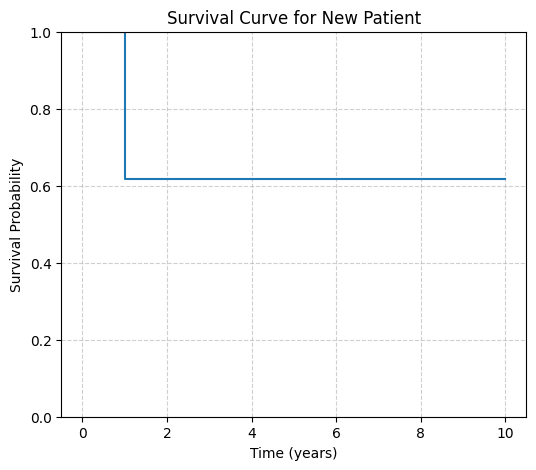

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Set a random seed for reproducibility
np.random.seed(123)

# Assuming 'data' DataFrame is already loaded and preprocessed from previous steps
# Assuming 'rsf', 'predict_rsf', 'build_survival_tree', 'predict_tree',
# 'bootstrap_sample', and 'log_rank_test' functions are already defined from previous steps.

# 2. Build the Random Survival Forest
# Use the 'data' DataFrame created in the preprocessing step
forest = rsf(data, n_trees=10, max_depth=3, min_node_size=5)

# 3. Create a pandas Series representing a new patient's data
# Ensure the features match the training data columns used in the trees
new_patient_data = {'age': 50, 'sex': 1, 'thickness': 2.5, 'ulcer': 1}
new_patient = pd.Series(new_patient_data)

# 4. Define an array of time points for prediction
times = np.arange(0, 11, 1)  # Predict survival from 0 to 10 years

# 5. Predict the survival probabilities for the new patient
prediction = predict_rsf(forest, new_patient, times)

# 6. Print the predicted survival probabilities
print(pd.DataFrame({'Time': prediction['times'], 'Survival': np.round(prediction['survival'], 4)}))

# 7. Plot the survival curve
plt.figure(figsize=(6, 5)) # Optional: Adjust figure size
plt.step(prediction['times'], prediction['survival'], where='post') # Use step plot

# 8. Add labels and title, set y-axis limits
plt.xlabel("Time (years)")
plt.ylabel("Survival Probability")
plt.title("Survival Curve for New Patient")
plt.ylim(0, 1)
plt.grid(True, linestyle='--', alpha=0.6) # Optional: Add grid

# 9. Display the plot
plt.show()

## Random Survival Forest in Python

Random Survival Forest (RSF) is a machine learning model used for survival analysis, extending Random Forests to handle censored data. Several Python libraries provide implementations or support for Random Survival Forests. Below is a list of the main libraries available as of my last update:

1. **scikit-survival**:
   - **Description**: A Python library specifically designed for survival analysis, built on top of scikit-learn. It includes an implementation of Random Survival Forests (`RandomSurvivalForest`).
   - **Features**:
     - Handles right-censored data.
     - Provides tools for survival prediction, feature importance, and concordance index evaluation.
     - Compatible with scikit-learn’s API, making it easy to integrate with other machine learning workflows.
   - **Installation**: `pip install scikit-survival`

2. **lifelines**:
   - **Description**: A comprehensive library for survival analysis in Python. While it does not directly implement Random Survival Forests, it provides utilities for survival data preprocessing and evaluation that can be used with RSF models from other libraries (e.g., scikit-survival).
   - **Features**:
     - Extensive survival analysis tools (e.g., Kaplan-Meier, CoxPH).
     - Useful for data preparation and visualization in survival analysis workflows.
   - **Installation**: `pip install lifelines`
   - **Use Case**: Combine with `scikit-survival` for data preprocessing or evaluation metrics.
   - **Documentation**: https://lifelines.readthedocs.io/

3. **PySurvival** (Deprecated/Unsupported):
   - **Description**: Previously offered survival analysis models, including Random Survival Forests. However, this library is no longer actively maintained, and its use is not recommended for new projects.
   - **Alternative**: Use `scikit-survival` instead, as it is actively maintained and more robust.

4. **Custom Implementations**:
   - Libraries like **scikit-learn** can be extended to implement Random Survival Forests by adapting decision trees for survival data. However, this requires significant custom coding, as scikit-learn does not natively support survival analysis.
   - You can use scikit-learn’s `RandomForestRegressor` or `RandomForestClassifier` as a base and modify the loss function for survival data, but this is complex and not recommended unless you have specific needs.

**{scikit-survival}** is the go-to choice for Random Survival Forests in Python due to its robust implementation, active maintenance, and compatibility with scikit-learn’s ecosystem. It is well-documented and widely used in survival analysis tasks.





### Random Survival Forest using {scikit-survival} package

In this section, we will implement a Random Survival Forest using the `{scikit-survival}` package in Python. We will use the Melanoma dataset  which contains survival data for patients with Melanoma skin cancer.

The code follows the same steps as the R code, including data preprocessing, fitting a Random Survival Forest model, evaluating performance with the concordance index, predicting survival functions, computing Brier scores, calculating CRPS, and analyzing variable importance. Note that some functionalities (e.g., competing risks, specific plotting functions like `plot.survival` or `plot.competing.risk`) are not directly available in {scikit-survival}, so I’ve provided alternatives or noted limitations.





In [22]:
!pip install scikit-survival
!pip install lifelines

In [ ]:
!pip install scipy

In [27]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sksurv.ensemble import RandomSurvivalForest
from sksurv.util import Surv
from sksurv.metrics import concordance_index_censored, brier_score
from lifelines.utils import survival_table_from_events
# from scipy.integrate import trapz # Corrected import

### Data

The Melanoma data frame has data on 205 patients in Denmark with malignant Melanoma.
This data frame contains the following columns:

`time` - survival time in days, possibly censored.

`status` - 1 died from Melanoma, 2 alive, 3 dead from other causes.

`sex` - 1 = male, 0 = female.

`age` - age in years.

`year`- year of operation.

`thickness` - tumour thickness in mm.

`ulcer` - 1 = presence, 0 = absence.

In [28]:
# Load and Preprocess the Melanoma Dataset

# Set random seed for reproducibility
np.random.seed(123)

### Load and Preprocess the Melanoma Dataset

# Load the dataset from the provided URL
data = pd.read_csv("https://raw.githubusercontent.com/zia207/r-colab/main/Data/Machine_Learning/Melanoma.csv")

# Convert 'time' from days to years
data['time'] = data['time'] / 365

# Recode 'status': 1 for death from melanoma (event), 0 for censored (alive or other causes)
data['status'] = data['status'].apply(lambda x: 1 if x == 1 else 0)

# Select relevant columns
data = data[['time', 'status', 'age', 'sex', 'thickness', 'ulcer']]

# Remove rows with missing values
data = data.dropna()

# Display the first few rows
print(data.head())



       time  status  age  sex  thickness  ulcer
0  0.000075       0   76    1       6.76      1
1  0.000225       0   56    1       0.65      0
2  0.000263       0   41    1       1.34      0
3  0.000743       0   71    0       2.90      0
4  0.001389       1   52    1      12.08      1


### Define Survival Data

The `Surv` function from {scikit-survival} creates a structured array for survival data, combining time and status.

In [ ]:
# Create structured array for survival data (required by scikit-survival)
y = Surv().from_arrays(event=data['status'].astype(bool), time=data['time'])
X = data[['age', 'sex', 'thickness', 'ulcer']]

### Fit Random Survival Forest Model

The `RandomSurvivalForest` from {scikit-survival} is used with parameters similar to the R code (n_estimators=1000, min_samples_leaf=5).

The year variable was not included in the predictors because it’s not present in the dataset loaded from the provided URL. If needed, adjust the code to include it if available.

In [29]:
# Initialize and fit the RSF model
rsf = RandomSurvivalForest(
    n_estimators=1000,  # Number of trees
    min_samples_leaf=5,  # Minimum number of events in terminal nodes
    n_jobs=-1,  # Use all available cores
    random_state=123
)
rsf.fit(X, y)

# Print model details
print("\nRandom Survival Forest Model:")
print(rsf)


Random Survival Forest Model:
RandomSurvivalForest(min_samples_leaf=5, n_estimators=1000, n_jobs=-1,
                     random_state=123)


### Calculate Concordance Index (C-index)

The `C-index (concordance index)` also known as the concordance index or Harrell’s concordance index, is a metric used in survival analysis to evaluate the predictive performance of a model, such as a Random Survival Forest. It measures the model’s ability to correctly rank pairs of individuals based on their survival times, i.e., whether the model predicts a higher risk or shorter survival time for the individual who experiences the event (e.g., death) sooner. The C-index can be calculated as 1 - C-error rate, where C-error rate is the final out-of-bag (OOB) error rate.  Lower C-error (higher C-index) indicates better ranking performance

C-index ranges from 0 to 1:

-   1: Perfect ranking (model correctly orders all pairs).

-   0.5: Random guessing (no predictive power).

-   0: Completely incorrect ranking.
    (no discrimination) to 1 (perfect discrimination).


he C-index is computed using `rsf.score()`, which returns Harrell’s concordance index.

In [30]:
# Calculate concordance index (Harrell's C-index)
c_index = rsf.score(X, y)
print(f"\nC-index: {c_index:.4f}")


C-index: 0.8619


### Plot Survival Functions

Survival functions for hypothetical individuals are plotted using `predict_survival_function`.

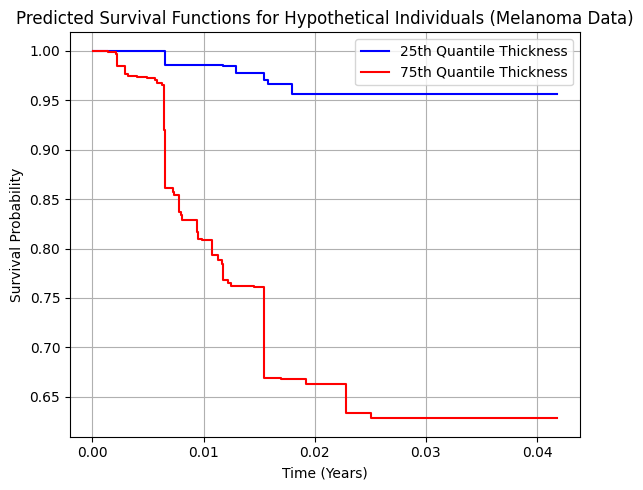

In [33]:
# Note: scikit-survival does not have a direct equivalent to R's plot.survival with Kaplan-Meier censoring.
# Instead, we plot survival curves for hypothetical individuals as done in the R code.

# Create hypothetical individuals
median_values = X[['age', 'sex', 'ulcer']].median()
thickness_quantiles = X['thickness'].quantile([0.25, 0.75])

# Individual 1: thickness at 25th quantile, others at median
ind1 = pd.DataFrame({
    'age': [median_values['age']],
    'sex': [median_values['sex']],
    'thickness': [thickness_quantiles[0.25]],
    'ulcer': [median_values['ulcer']]
})

# Individual 2: thickness at 75th quantile, others at median
ind2 = pd.DataFrame({
    'age': [median_values['age']],
    'sex': [median_values['sex']],
    'thickness': [thickness_quantiles[0.75]],
    'ulcer': [median_values['ulcer']]
})

# Combine hypothetical individuals
hypothetical_data = pd.concat([ind1, ind2], ignore_index=True)

# Predict survival functions
surv_funcs = rsf.predict_survival_function(hypothetical_data)

# Plot survival functions
plt.figure(figsize=(6, 5))
for i, surv_func in enumerate(surv_funcs):
    label = "25th Quantile Thickness" if i == 0 else "75th Quantile Thickness"
    # Evaluate the survival function at the unique times from the training data
    plt.step(rsf.unique_times_, surv_func(rsf.unique_times_), where="post", label=label, color=['blue', 'red'][i])
plt.title("Predicted Survival Functions for Hypothetical Individuals (Melanoma Data)")
plt.xlabel("Time (Years)")
plt.ylabel("Survival Probability")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()

### Compute Brier Scores

The Brier Score is a metric used in survival analysis to evaluate the accuracy of probabilistic predictions, particularly for survival models like Random Survival Forests. It measures the mean squared difference between the predicted survival probabilities and the actual survival outcomes, accounting for censoring in survival data.

Brier scores are computed using `sksurv.metrics.brier_score` with Kaplan-Meier censoring. RSF-based censoring is not supported in {scikit-survival}, so only Kaplan-Meier is shown.

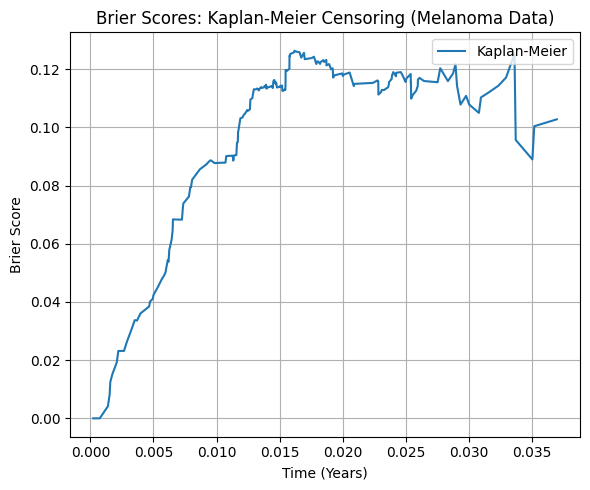

In [37]:
# Compute Brier scores at event times
# Note: scikit-survival uses Kaplan-Meier for censoring distribution by default

# Filter times to be strictly within the observed follow-up time of test data
test_times = y['time']
min_test_time = test_times.min()
max_test_time = test_times.max()

# Filter rsf.unique_times_ to be > min_test_time and < max_test_time
eval_times = rsf.unique_times_[(rsf.unique_times_ > min_test_time) & (rsf.unique_times_ < max_test_time)]

# Ensure eval_times is not empty after filtering
if len(eval_times) == 0:
    print("Warning: No valid evaluation times after filtering. Brier score cannot be computed.")
else:
    # Get survival functions and evaluate them at the filtered times
    surv_funcs = rsf.predict_survival_function(X)
    surv_prob = np.vstack([f(eval_times) for f in surv_funcs])

    times, brier_scores = brier_score(y, y, surv_prob, eval_times)

    # Create DataFrame for plotting
    plot_data_brier = pd.DataFrame({
        'Time': times,
        'BrierScore': brier_scores,
        'Method': 'Kaplan-Meier'
    })

    # Plot Brier scores
    plt.figure(figsize=(6, 5))
    sns.lineplot(data=plot_data_brier, x='Time', y='BrierScore', hue='Method', style='Method', color='blue')
    plt.title("Brier Scores: Kaplan-Meier Censoring (Melanoma Data)")
    plt.xlabel("Time (Years)")
    plt.ylabel("Brier Score")
    plt.legend(loc="upper right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### Calculate Continuous Rank Probability Score (CRPS)

The Continuous Rank Probability Score (CRPS) is a metric used to evaluate the accuracy of probabilistic forecasts, particularly in survival analysis.
It measures the difference between the predicted and observed survival distributions over time.
The CRPS is calculated as the integrated Brier score divided by the time interval (`t-0`).
The CRPS ranges from 0 to 1, where lower values indicate better predictive accuracy.
The CRPS is particularly useful for evaluating survival models, as it accounts for the entire survival distribution rather than just point estimates.

CRPS at time $t$ is defined as the integral of the Brier Score from $0$ to $t$, divided by the time range ($t - 0$).
The `trapz` function implements the trapezoidal rule to numerically integrate the Brier Score over time.
For each time point, CRPS is computed as:

$$   \text{CRPS}(t) = \frac{\int_0^t \text{Brier}(s) \, ds}{t - 0} $$

-   At $t=0$, CRPS is set to 0 (no prediction error at the start).

-   The `trapezoidal rule` is used to calculate the CRPS by integrating the Brier score over time.
    The CRPS is calculated for both Kaplan-Meier and RSF methods, and the results are plotted for comparison.


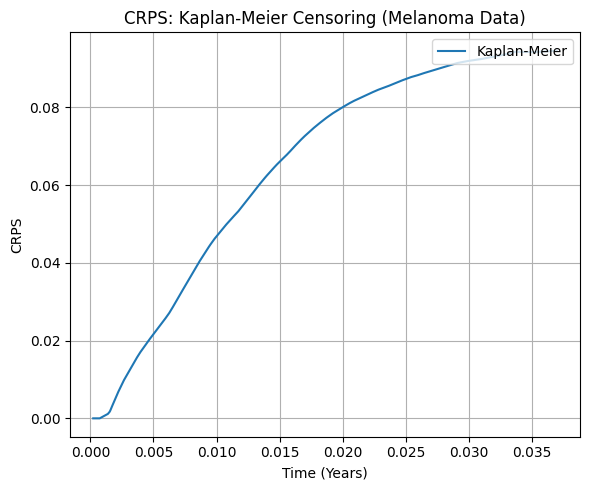

CRPS (Kaplan-Meier) at max time: 0.0946


In [40]:
# Import trapezoid from scipy.integrate
from scipy.integrate import trapezoid

# Calculate CRPS using trapezoidal integration
crps = []
for j in range(len(times)):
    if j == 0:
        crps.append(0)  # CRPS is 0 at t=0
    else:
        crps.append(trapezoid(brier_scores[:j+1], times[:j+1]) / (times[j] - times[0]))

# Create DataFrame for plotting
plot_data_crps = pd.DataFrame({
    'Time': times,
    'CRPS': crps,
    'Method': 'Kaplan-Meier'
})

# Plot CRPS
plt.figure(figsize=(6, 5))
sns.lineplot(data=plot_data_crps, x='Time', y='CRPS', hue='Method', style='Method', color='blue')
plt.title("CRPS: Kaplan-Meier Censoring (Melanoma Data)")
plt.xlabel("Time (Years)")
plt.ylabel("CRPS")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()

# Print CRPS at the final time point
print(f"CRPS (Kaplan-Meier) at max time: {crps[-1]:.4f}")

### Variable Importance (VIMP)

Feature importance is extracted using rsf.feature_importances_ and plotted as a bar chart with seaborn.


Variable Importance (VIMP):
    Variable  Importance
2  thickness    0.209594
0        age    0.075664
3      ulcer    0.064061
1        sex    0.025006


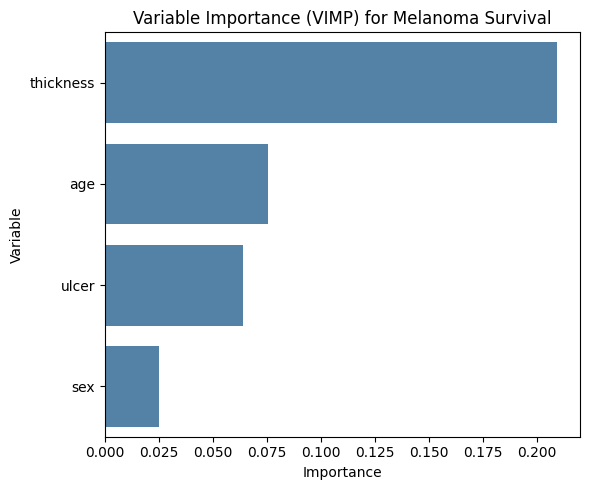

In [43]:
import numpy as np
from sksurv.metrics import concordance_index_censored

# Function to compute permutation-based variable importance
def compute_permutation_importance(rsf, X, y, n_permutations=10, random_state=123):
    np.random.seed(random_state)
    baseline_score = rsf.score(X, y)  # Concordance index on original data
    importance = {}

    for col in X.columns:
        scores = []
        X_permuted = X.copy()
        for _ in range(n_permutations):
            # Permute the current feature
            X_permuted[col] = np.random.permutation(X_permuted[col].values)
            # Compute concordance index with permuted feature
            score = rsf.score(X_permuted, y)
            scores.append(score)
        # Importance is the drop in performance (baseline - mean permuted score)
        importance[col] = baseline_score - np.mean(scores)

    return importance

# Calculate variable importance
vimp = compute_permutation_importance(rsf, X, y, n_permutations=10, random_state=123)
vimp_df = pd.DataFrame({
    'Variable': list(vimp.keys()),
    'Importance': list(vimp.values())
}).sort_values(by='Importance', ascending=False)

# Print VIMP
print("\nVariable Importance (VIMP):")
print(vimp_df)

# Plot VIMP
plt.figure(figsize=(6, 5))
sns.barplot(data=vimp_df, x='Importance', y='Variable', color='steelblue')
plt.title("Variable Importance (VIMP) for Melanoma Survival")
plt.xlabel("Importance")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()

###  Competting Risks

scikit-survival does not natively support competing risks analysis (e.g., Cause-Specific Cumulative Hazard Function or Cumulative Incidence Function).
To handle competing risks, you would need to reate a custom Python function to perform competing risks analysis using a Random Survival Forest approach. The function should be able to estimat:

* `Cause-Specific Cumulative Hazard Function (CSCHF)`: The instantaneous risk of an event type.

* `Cumulative Incidence Function (CIF)`: The probability of an event type occurring by time $t$ acccounting for competing events.

*  `Predicted Values`: The expected number of life years lost due to each event type.

 The function should handle data with a status column indicating different competing event types and censoring. The function should include steps for data preprocessing, building decision trees with a competing risks splitting criterion, predicting CSCHFs and CIFs, and potentially evaluating the model using appropriate metrics for competing risks.

#### Modify data preprocessing



In [51]:
import pandas as pd
import numpy as np

# 1. Load the Melanoma dataset
# Use the raw data URL from GitHub
data_raw = pd.read_csv("https://raw.githubusercontent.com/zia207/r-colab/main/Data/Machine_Learning/Melanoma.csv")

# 2. Convert the 'time' column from days to years by dividing by 365.
data_raw['time'] = data_raw['time'] / 365

# 3. Create a new event indicator column ('event_type')
# R status: 1=died from melanoma, 2=alive, 3=died from other causes
# Target Python event_type: 1=death from melanoma, 3=death from other causes, 0=censored (alive)
data_raw['event_type'] = data_raw['status'].apply(lambda x: x if x in [1, 3] else 0)

# 4. Select the relevant columns for the analysis: the new event indicator column, 'time', and the predictor variables
data_cr = data_raw[['time', 'event_type', 'age', 'sex', 'thickness', 'ulcer']]

# 5. Remove any rows containing missing values in the selected columns.
data_cr = data_cr.dropna()

# 6. Store the resulting DataFrame in a variable named data_cr. (Done in step 4)

# 7. Display the first few rows of the processed data for competing risks analysis.
display(data_cr.head())

,time,event_type,age,sex,thickness,ulcer
0,0.000075,0,76,1,6.76,1
1,0.000225,0,56,1,0.65,0
2,0.000263,0,41,1,1.34,0
3,0.000743,0,71,0,2.90,0
4,0.001389,1,52,1,12.08,1


#### Develop a competing risks splitting criterion

Implement a new function to replace or adapt the log-rank test for splitting nodes in the decision trees, considering multiple event types.

Define the `competing_risks_split_criterion` function in Python to implement a competing risks specific splitting criterion for decision trees, handling data splitting and calculating a test statistic to measure the separation of event types and censoring between child nodes, while ensuring valid splits.


In [52]:
import numpy as np
import pandas as pd

def competing_risks_split_criterion(data, split_var, split_point, is_categorical=False):
    """
    Calculates a competing risks split criterion statistic for a given split.

    This function adapts the log-rank test principle for competing risks,
    measuring the separation of event types and censoring between two groups
    formed by the split. It uses a weighted sum of cause-specific log-rank
    statistics.

    Args:
        data (pd.DataFrame): The dataset for the current node with 'time',
                             'event_type', and splitting variable columns.
                             'event_type' should be 0 for censored, and > 0
                             for specific event types.
        split_var (str): The name of the variable to split on.
        split_point (float or str): The threshold or category for the split.
        is_categorical (bool): True if split_var is categorical, False otherwise.

    Returns:
        float: The competing risks split statistic, or -inf if calculation
               is not meaningful or the split is invalid.
    """
    # Handle potential missing values in relevant columns
    # Drop rows where time, event_type, or split_var is NA
    temp_df = data[['time', 'event_type', split_var]].dropna()

    # Ensure there's enough data to attempt a split
    # A valid split requires at least some data and at least one event across all types
    if temp_df.empty or temp_df['event_type'].sum() == 0:
        return -np.inf

    # Split data into two groups
    if is_categorical:
        group1_mask = temp_df[split_var] == split_point
    else:
        group1_mask = temp_df[split_var] <= split_point

    group1_df = temp_df[group1_mask]
    group2_df = temp_df[~group1_mask]

    # Ensure both groups have data for a meaningful split
    if group1_df.empty or group2_df.empty:
        return -np.inf

    # Get unique event types (excluding censoring)
    event_types = sorted(temp_df['event_type'].unique())
    event_types = [et for et in event_types if et > 0] # Exclude censoring (event_type 0)

    # If no events of any type, return -inf
    if not event_types:
        return -np.inf

    # Calculate a combined test statistic. A simple approach is a sum of
    # cause-specific log-rank statistics. More complex methods exist but
    # this provides a reasonable adaptation.

    total_stat = 0
    # We need to consider unique times across all events for each cause-specific test
    all_event_times = np.sort(temp_df[temp_df['event_type'] > 0]['time'].unique())

    if len(all_event_times) == 0:
         return -np.inf # No event times to evaluate

    for event_type in event_types:
        # For each cause-specific test, we treat other event types as censoring
        # This is a simplified approach for adaptation; a full competing risks
        # split criterion might use multi-state models or other complex methods.

        # Get unique times for the current event type across the node
        cause_specific_event_times = np.sort(temp_df[temp_df['event_type'] == event_type]['time'].unique())

        if len(cause_specific_event_times) == 0:
             continue # No events of this type in the node

        cause_stat = 0
        for t in cause_specific_event_times:
            # Individuals at risk just before time t (anyone whose time is >= t, regardless of event type)
            at_risk1 = (group1_df['time'] >= t).sum()
            at_risk2 = (group2_df['time'] >= t).sum()
            total_at_risk = at_risk1 + at_risk2

            # Events of *this specific type* at time t
            events1 = ((group1_df['time'] == t) & (group1_df['event_type'] == event_type)).sum()
            events2 = ((group2_df['time'] == t) & (group2_df['event_type'] == event_type)).sum()
            total_cause_events = events1 + events2

            if total_at_risk > 0:
                # Expected events of this cause in group 1 under the null
                expected1 = at_risk1 * total_cause_events / total_at_risk

                # Variance approximation for this cause-specific test
                # This variance calculation is adapted for cause-specific events
                # See references like "Competing Risks and Multistate Models" by Andersen et al.
                # or "Random Survival Forests" by Ishwaran et al. for more details on variance
                # under competing risks. A simplified variance for cause-specific log-rank:
                if total_at_risk > 1 and total_cause_events > 0 and total_at_risk - total_cause_events > 0:
                    variance = (at_risk1 * at_risk2 * total_cause_events * (total_at_risk - total_cause_events)) / \
                               (total_at_risk**2 * (total_at_risk - 1))

                    if variance > 1e-9: # Avoid division by near zero
                         cause_stat += (events1 - expected1)**2 / variance
                elif events1 - expected1 != 0:
                     # If variance is zero but there is a difference, indicates perfect separation for this cause
                     # For a combined statistic, we can add a large value, or handle it as a special case.
                     # Adding a large value biases towards splits that perfectly separate one cause.
                     # Let's return inf if any cause-specific test has perfect separation, making the overall split very good.
                     return np.inf


        # Add the statistic for this event type to the total.
        # We might weight these statistics, but for simplicity, we sum.
        # If a cause_stat is inf, the loop would have returned inf already.
        if np.isfinite(cause_stat):
             total_stat += cause_stat
        else:
             # If a cause-specific stat is NaN or non-finite for some reason other than perfect separation
             # (which returns inf), this indicates a problem with this split for this cause.
             # Return -inf to indicate an invalid split.
             return -np.inf


    # Ensure the total statistic is finite and non-negative before returning
    if not np.isfinite(total_stat) or total_stat < 0:
         return -np.inf


    return total_stat


#### Update tree building for competing risks

Modify the `build_survival_tree` function to use the competing risks splitting criterion and to calculate Cause-Specific Cumulative Hazard Functions (CSCHFs) at the leaf nodes for each event type.


In [53]:
import numpy as np
import pandas as pd

def build_survival_tree_cr(data, max_depth, min_node_size, depth=0):
    """
    Builds a single survival tree for competing risks data.

    Args:
        data (pd.DataFrame): The dataset for the current node with 'time' and 'event_type'.
        max_depth (int): Maximum depth of the tree.
        min_node_size (int): Minimum number of observations in a node to split.
        depth (int): Current depth of the tree.

    Returns:
        dict: A dictionary representing the node or leaf, containing split information
              or CSCHF estimates.
    """
    # Filter out rows with NA in time or event_type early
    data = data.dropna(subset=['time', 'event_type'])

    # Stop criteria: max depth, too few observations, or no valid data
    # For competing risks, we stop if len(data) < min_node_size or if there are no events (event_type > 0)
    if depth >= max_depth or len(data) < min_node_size or (data['event_type'] > 0).sum() == 0:
        # Leaf node: Calculate Cause-Specific Cumulative Hazard Functions (CSCHFs)
        unique_event_types = sorted(data['event_type'].unique())
        event_types_present = [et for et in unique_event_types if et > 0]

        # Get all unique times where any event occurred in this leaf
        all_event_times_in_leaf = np.sort(data[data['event_type'] > 0]['time'].unique())

        cschf_dict = {}
        if len(all_event_times_in_leaf) > 0:
            for event_type in event_types_present:
                cschf_values = []
                for t in all_event_times_in_leaf:
                    # Number of events of this specific type at time t
                    d_itk = ((data['time'] == t) & (data['event_type'] == event_type)).sum()
                    # Number of individuals at risk just before time t (regardless of event type)
                    n_i = (data['time'] >= t).sum()
                    cschf_values.append(d_itk / n_i if n_i > 0 else 0)
                cschf = np.cumsum(cschf_values)
                cschf_dict[int(event_type)] = {"times": all_event_times_in_leaf.tolist(), "chf": cschf.tolist()}
        # If no events, the CSCHF for all event types is 0 across all times.
        # We should still return a structure, maybe with placeholder times or just 0 CHF.
        # Let's define times based on the data present, even if no events occurred.
        else:
             # If no events occurred, define a trivial CSCHF of 0 for relevant time range
             max_time = data['time'].max() if not data['time'].empty and data['time'].max() is not np.nan else 10
             # Use a small range or just 0, 1 for placeholder times if no events
             placeholder_times = [0.0, max_time + 1e-9] # Ensure at least two points

             for event_type in event_types_present:
                  cschf_dict[int(event_type)] = {"times": placeholder_times, "chf": [0.0, 0.0]}


        return {"type": "leaf", "cschf": cschf_dict}

    # Select random features (ensure 'time' and 'event_type' are excluded)
    features = [col for col in data.columns if col not in ['time', 'event_type']]
    available_features_in_data = [f for f in features if f in data.columns]

    if not available_features_in_data:
         # If no features to split on, return leaf (calculate CSCHFs as above)
        unique_event_types = sorted(data['event_type'].unique())
        event_types_present = [et for et in unique_event_types if et > 0]
        all_event_times_in_leaf = np.sort(data[data['event_type'] > 0]['time'].unique())

        cschf_dict = {}
        if len(all_event_times_in_leaf) > 0:
            for event_type in event_types_present:
                cschf_values = []
                for t in all_event_times_in_leaf:
                    d_itk = ((data['time'] == t) & (data['event_type'] == event_type)).sum()
                    n_i = (data['time'] >= t).sum()
                    cschf_values.append(d_itk / n_i if n_i > 0 else 0)
                cschf = np.cumsum(cschf_values)
                cschf_dict[int(event_type)] = {"times": all_event_times_in_leaf.tolist(), "chf": cschf.tolist()}
        else:
             max_time = data['time'].max() if not data['time'].empty and data['time'].max() is not np.nan else 10
             placeholder_times = [0.0, max_time + 1e-9]
             for event_type in event_types_present:
                  cschf_dict[int(event_type)] = {"times": placeholder_times, "chf": [0.0, 0.0]}

        return {"type": "leaf", "cschf": cschf_dict}


    # Select a subset of available features (e.g., min(2, number of available features))
    n_features_to_select = min(2, len(available_features_in_data))
    selected_features = np.random.choice(available_features_in_data, size=n_features_to_select, replace=False)

    # Find best split using the competing risks criterion
    best_stat = -np.inf
    best_feature = None
    best_split = None

    for feature in selected_features:
        # Determine if the feature is categorical based on common practice or predefined list
        # Here, assuming 'sex' and 'ulcer' are categorical based on the original data description
        is_categorical = feature in ['sex', 'ulcer']
        feature_data = data[feature].dropna() # Drop NAs for split point calculation

        if feature_data.empty:
            continue # Skip feature if all values are NA

        if not is_categorical:
            # Use unique values as potential split points to handle small datasets or discrete values
            split_points = feature_data.unique()
            if len(split_points) > 10: # For larger unique values, use quantiles
                 split_points = np.quantile(feature_data, q=np.linspace(0.1, 0.9, 9))
            split_points = np.sort(np.unique(split_points)) # Ensure unique and sorted
        else:
            split_points = feature_data.unique()

        for sp in split_points:
            # Ensure split point is not NaN before using it
            if pd.isna(sp):
                continue

            # Calculate competing risks split statistic
            # Pass the original data to the criterion function, it handles NAs internally
            stat = competing_risks_split_criterion(data, feature, sp, is_categorical)

            if stat > best_stat:
                best_stat = stat
                best_feature = feature
                best_split = sp

    # If no valid split found (best_stat is still -inf), return leaf
    if best_feature is None or best_stat == -np.inf:
        unique_event_types = sorted(data['event_type'].unique())
        event_types_present = [et for et in unique_event_types if et > 0]
        all_event_times_in_leaf = np.sort(data[data['event_type'] > 0]['time'].unique())

        cschf_dict = {}
        if len(all_event_times_in_leaf) > 0:
            for event_type in event_types_present:
                cschf_values = []
                for t in all_event_times_in_leaf:
                    d_itk = ((data['time'] == t) & (data['event_type'] == event_type)).sum()
                    n_i = (data['time'] >= t).sum()
                    cschf_values.append(d_itk / n_i if n_i > 0 else 0)
                cschf = np.cumsum(cschf_values)
                cschf_dict[int(event_type)] = {"times": all_event_times_in_leaf.tolist(), "chf": cschf.tolist()}
        else:
             max_time = data['time'].max() if not data['time'].empty and data['time'].max() is not np.nan else 10
             placeholder_times = [0.0, max_time + 1e-9]
             for event_type in event_types_present:
                  cschf_dict[int(event_type)] = {"times": placeholder_times, "chf": [0.0, 0.0]}

        return {"type": "leaf", "cschf": cschf_dict}


    # Split data based on feature type and best split point
    # Ensure NAs in the split feature are handled consistently with how the criterion function might handle them
    # The criterion function drops NAs in the split_var for the split calculation.
    # For splitting the data, we should probably also drop rows where the best_feature is NA.
    data_for_split = data.dropna(subset=[best_feature])

    if best_feature in ['sex', 'ulcer']:
        left_data = data_for_split[data_for_split[best_feature] == best_split]
        right_data = data_for_split[data_for_split[best_feature] != best_split]
    else:
        left_data = data_for_split[data_for_split[best_feature] <= best_split]
        right_data = data_for_split[data_for_split[best_feature] > best_split]


    # Ensure child nodes have enough data before attempting to split further
    if len(left_data) < min_node_size or len(right_data) < min_node_size:
         # If split results in too small nodes, return leaf for the current data
        unique_event_types = sorted(data['event_type'].unique())
        event_types_present = [et for et in unique_event_types if et > 0]
        all_event_times_in_leaf = np.sort(data[data['event_type'] > 0]['time'].unique())

        cschf_dict = {}
        if len(all_event_times_in_leaf) > 0:
            for event_type in event_types_present:
                cschf_values = []
                for t in all_event_times_in_leaf:
                    d_itk = ((data['time'] == t) & (data['event_type'] == event_type)).sum()
                    n_i = (data['time'] >= t).sum()
                    cschf_values.append(d_itk / n_i if n_i > 0 else 0)
                cschf = np.cumsum(cschf_values)
                cschf_dict[int(event_type)] = {"times": all_event_times_in_leaf.tolist(), "chf": cschf.tolist()}
        else:
             max_time = data['time'].max() if not data['time'].empty and data['time'].max() is not np.nan else 10
             placeholder_times = [0.0, max_time + 1e-9]
             for event_type in event_types_present:
                  cschf_dict[int(event_type)] = {"times": placeholder_times, "chf": [0.0, 0.0]}

        return {"type": "leaf", "cschf": cschf_dict}

    # Recursively build left and right subtrees
    left_tree = build_survival_tree_cr(left_data, max_depth, min_node_size, depth + 1)
    right_tree = build_survival_tree_cr(right_data, max_depth, min_node_size, depth + 1)

    return {"type": "node", "feature": best_feature, "split": best_split,
            "left": left_tree, "right": right_tree}


#### Update prediction for competing risks

Modify the `predict_tree` function to return the CSCHFs for all event types from a leaf node.


In [54]:
import numpy as np
import pandas as pd

def predict_tree_cr(tree, x):
    """
    Predicts the CSCHFs for a single observation by traversing a competing risks survival tree.

    Args:
        tree (dict): A dictionary representing the competing risks survival tree structure.
        x (pd.Series): A pandas Series representing the observation to predict.

    Returns:
        dict: A dictionary containing 'times' and 'cschf' dictionaries for each event type
              from the leaf node.
    """
    # Base case: If it's a leaf node, return its CSCHF dictionary
    if tree['type'] == 'leaf':
        # Ensure cschf is a dictionary with event type keys and {"times": ..., "chf": ...} values
        # Handle cases where a leaf might have no events and the structure is different
        if 'cschf' in tree and isinstance(tree['cschf'], dict):
            # Convert times and chf lists to numpy arrays for consistency if needed later
            # For now, just return the structure as built
            return tree['cschf']
        else:
            # Return an empty dictionary or a specific indicator if leaf structure is unexpected
            print("Warning: Leaf node structure is missing or incorrect 'cschf' key.")
            return {}

    # If it's a decision node
    feature = tree['feature']
    split_point = tree['split']
    feature_value = x.get(feature) # Use .get() to handle cases where feature might be missing in x

    # Handle missing feature value or split point by defaulting to one child (e.g., left)
    if pd.isna(feature_value) or pd.isna(split_point):
        # print(f"Warning: Missing value for feature '{feature}' or split point {split_point}. Defaulting to left child.")
        return predict_tree_cr(tree['left'], x)

    # Determine which child node to go to based on the split
    # Assuming 'sex' and 'ulcer' are the categorical features as in the original R code
    is_categorical = feature in ['sex', 'ulcer']

    if is_categorical:
        if feature_value == split_point:
            return predict_tree_cr(tree['left'], x)
        else:
            return predict_tree_cr(tree['right'], x)
    else: # Continuous feature
        if feature_value <= split_point:
            return predict_tree_cr(tree['left'], x)
        else:
            return predict_tree_cr(tree['right'], x)

#### Update rsf prediction for competing risks


Modify the `predict_rsf` function to aggregate CSCHFs across all trees and calculate the Cumulative Incidence Functions (CIFs) for each competing event type.


In [55]:
import numpy as np
import pandas as pd
from scipy.integrate import cumulative_trapezoid # Use cumulative_trapezoid for cumulative integral

def predict_rsf_cr(trees, x, times):
    """
    Predicts the Cumulative Incidence Functions (CIFs) for a new observation
    using a Competing Risks Random Survival Forest.

    Args:
        trees (list): A list of trained competing risks survival trees (dictionaries).
        x (pd.Series): A pandas Series representing the observation to predict.
        times (np.ndarray or list): An array of time points at which to predict CIFs.

    Returns:
        dict: A dictionary where keys are event types and values are lists or arrays
              of CIF values corresponding to the input `times`.
              Optionally, also returns the overall survival function.
    """
    # Convert times to a numpy array
    times = np.asarray(times)

    # Identify all unique event types present in the forest
    # This requires traversing the trees to find all event types in leaf nodes
    all_event_types = set()
    def find_event_types(tree):
        if tree['type'] == 'leaf' and 'cschf' in tree:
            all_event_types.update(tree['cschf'].keys())
        elif tree['type'] == 'node':
            find_event_types(tree['left'])
            find_event_types(tree['right'])

    for tree in trees:
        find_event_types(tree)

    event_types = sorted(list(all_event_types)) # Get unique event types sorted

    # Initialize dictionaries to store aggregated CSCHFs for each event type
    # Shape: (n_trees, n_times) for each event type
    aggregated_cschfs = {et: np.zeros((len(trees), len(times))) for et in event_types}

    # For each tree, predict CSCHF and aggregate
    for i, tree in enumerate(trees):
        # Get the CSCHF predictions from a single tree for the observation x
        tree_cschfs = predict_tree_cr(tree, x) # Assumes predict_tree_cr is defined

        # Interpolate each cause-specific CHF from the tree onto the prediction times
        for event_type in event_types:
            if event_type in tree_cschfs and len(tree_cschfs[event_type]['times']) > 0:
                 tree_times = np.asarray(tree_cschfs[event_type]['times'])
                 tree_chf = np.asarray(tree_cschfs[event_type]['chf'])
                 # Interpolate using np.interp
                 aggregated_cschfs[event_type][i, :] = np.interp(times, tree_times, tree_chf,
                                                                 left=0, right=tree_chf[-1])
            else:
                # If a tree leaf has no events of this type, its CSCHF is 0 everywhere
                aggregated_cschfs[event_type][i, :] = np.zeros_like(times, dtype=float)


    # Calculate the mean CSCHF across all trees for each event type at each time point
    mean_cschfs = {et: np.mean(aggregated_cschfs[et], axis=0) for et in event_types}

    # Calculate the overall cumulative hazard function H(t) = sum_k H_k(t)
    total_chf = np.sum(list(mean_cschfs.values()), axis=0)

    # Calculate the overall survival function S(t) = exp(-H(t))
    overall_survival = np.exp(-total_chf)

    # Calculate the Cumulative Incidence Function (CIF) for each event type k
    # CIF_k(t) = integral_0^t S(u-) dH_k(u)
    # Using numerical integration (cumulative trapezoidal rule)
    cifs = {}
    for event_type in event_types:
        mean_cschf_k = mean_cschfs[event_type]
        # Approximate the increment dH_k(u) as the difference in mean CSCHF at consecutive time points
        # Need to handle the first time point separately
        dh_k = np.diff(mean_cschf_k, prepend=0) # Prepend 0 to get increment at times[0]

        # Approximate S(u-) as the overall survival probability *at the previous time point*
        # Need to handle S(0-) which is 1
        survival_at_previous_times = np.concatenate(([1.0], overall_survival[:-1]))

        # The integrand is S(u-) * dH_k(u)
        integrand = survival_at_previous_times * dh_k

        # Calculate the cumulative integral
        cif_k = np.cumsum(integrand) # Cumulative sum for step-wise integration

        cifs[event_type] = cif_k.tolist() # Store as list

    # Return CIFs and optionally overall survival
    return {"times": times.tolist(), "cifs": cifs, "overall_survival": overall_survival.tolist()}

#### Develop evaluation metrics for competing risks


Implement or adapt metrics like the C-index or Brier score for competing risks to evaluate the model's performance for each event type.


In [56]:
import numpy as np
import pandas as pd
from sksurv.metrics import concordance_index_censored # Use as inspiration/reference
from lifelines.utils import survival_table_from_events # Potentially useful for KM censoring distribution
from scipy.integrate import trapezoid # For Integrated Brier Score

def concordance_index_competing_risks(event_times, event_types, predicted_risks, event_of_interest):
    """
    Calculates a concordance index for a specific competing event type.

    This metric evaluates how well the predicted risk for 'event_of_interest'
    ranks pairs of individuals who experienced 'event_of_interest'.

    Args:
        event_times (np.ndarray): Array of observed event/censoring times.
        event_types (np.ndarray): Array indicating event type (0 for censored,
                                  > 0 for specific event types).
        predicted_risks (np.ndarray): Array of predicted risks for the
                                     'event_of_interest' for each individual.
        event_of_interest (int): The specific event type to evaluate.

    Returns:
        float: The competing risks concordance index for the event of interest.
               Returns NaN if calculation is not possible (e.g., no events of interest).
    """
    # Filter for individuals who experienced the event of interest
    event_of_interest_mask = (event_types == event_of_interest)
    event_of_interest_times = event_times[event_of_interest_mask]
    event_of_interest_risks = predicted_risks[event_of_interest_mask]
    event_of_interest_indices = np.where(event_of_interest_mask)[0]

    n_events_of_interest = len(event_of_interest_times)

    if n_events_of_interest < 2:
        print(f"Warning: Not enough events of interest ({event_of_interest}) to compute C-index.")
        return np.nan

    # Identify comparable pairs
    # A pair (i, j) is comparable if:
    # 1. Both i and j experienced the event of interest.
    # 2. Their event times are different (t_i != t_j).
    # 3. The individual with the earlier event time (say i) has a higher predicted risk for the event of interest than the individual with the later event time (j).

    concordant_pairs = 0
    discordant_pairs = 0
    tied_pairs = 0
    comparable_pairs = 0

    # Iterate through all pairs of individuals who experienced the event of interest
    for i in range(n_events_of_interest):
        for j in range(i + 1, n_events_of_interest):
            idx_i = event_of_interest_indices[i]
            idx_j = event_of_interest_indices[j]

            time_i = event_of_interest_times[i]
            time_j = event_of_interest_times[j]
            risk_i = event_of_interest_risks[i]
            risk_j = event_of_interest_risks[j]

            # Check if event times are different
            if time_i != time_j:
                comparable_pairs += 1

                # Determine which individual had the earlier event
                if time_i < time_j:
                    # Individual i had the earlier event of interest
                    if risk_i > risk_j:
                        concordant_pairs += 1
                    elif risk_i < risk_j:
                        discordant_pairs += 1
                    else:
                        tied_pairs += 1 # Tied predicted risks
                else: # time_j < time_i
                    # Individual j had the earlier event of interest
                    if risk_j > risk_i:
                        concordant_pairs += 1
                    elif risk_j < risk_i:
                        discordant_pairs += 1
                    else:
                        tied_pairs += 1 # Tied predicted risks

    # Calculate C-index
    # C = (Concordant + 0.5 * Tied) / Comparable
    if comparable_pairs == 0:
        return np.nan # No comparable pairs

    c_index = (concordant_pairs + 0.5 * tied_pairs) / comparable_pairs

    return c_index


def brier_score_competing_risks(event_times, event_types, predicted_cifs, times, event_of_interest, censoring_distribution_survival=None):
    """
    Calculates the Brier score for a specific competing event type at given time points.

    This metric quantifies the accuracy of the predicted Cumulative Incidence Function (CIF)
    for 'event_of_interest', accounting for censoring and competing events.

    Args:
        event_times (np.ndarray): Array of observed event/censoring times.
        event_types (np.ndarray): Array indicating event type (0 for censored,
                                  > 0 for specific event types).
        predicted_cifs (dict): A dictionary where keys are event types and values
                               are arrays or lists of predicted CIFs for each individual
                               at the time points specified by `times`.
                               Shape of each value array should be (n_individuals, n_times).
        times (np.ndarray): Array of time points at which CIFs were predicted.
        event_of_interest (int): The specific event type to evaluate.
        censoring_distribution_survival (callable, optional): A function that takes
            an array of times and returns the estimated survival probability of the
            censoring distribution at those times. If None, a Kaplan-Meier estimate
            from the observed censoring times is used.

    Returns:
        tuple: A tuple containing:
            - np.ndarray: The time points at which Brier scores were calculated.
            - np.ndarray: The Brier scores at each time point.
            - np.ndarray: The Integrated Brier Score (IBS) over the given time range.
               Returns (times, np.full_like(times, np.nan), np.nan) if calculation
               is not possible.
    """
    if event_of_interest not in predicted_cifs:
        print(f"Error: Predicted CIFs for event type {event_of_interest} not found.")
        return times, np.full_like(times, np.nan), np.nan

    predicted_cif_k = np.asarray(predicted_cifs[event_of_interest]) # Shape (n_individuals, n_times)
    n_individuals = len(event_times)
    n_times = len(times)

    if predicted_cif_k.shape != (n_individuals, n_times):
         print(f"Error: Shape mismatch for predicted CIFs. Expected {(n_individuals, n_times)}, got {predicted_cif_k.shape}")
         return times, np.full_like(times, np.nan), np.nan


    # Estimate the censoring distribution if not provided
    if censoring_distribution_survival is None:
        # Estimate censoring survival using Kaplan-Meier on censoring times
        censoring_times = event_times[event_types == 0]
        censoring_status = np.ones_like(censoring_times, dtype=bool) # Treat censoring as event for this KM
        if len(censoring_times) > 0:
            from lifelines import KaplanMeierFitter
            kmf_censoring = KaplanMeierFitter()
            kmf_censoring.fit(censoring_times, event_observed=censoring_status)
            # Interpolate the KM censoring survival onto the prediction times
            km_cens_survival = kmf_censoring.survival_function_at_times(times).values
            # Handle times outside KM range (assume survival is 1 before min time, last value after max time)
            km_cens_survival[times < kmf_censoring.timeline.min()] = 1.0
            km_cens_survival[times > kmf_censoring.timeline.max()] = km_cens_survival[-1] if len(km_cens_survival) > 0 else 1.0
            censoring_survival_at_times = km_cens_survival
        else:
             # If no censoring observed, censoring survival is always 1
             censoring_survival_at_times = np.ones_like(times, dtype=float)
    else:
        censoring_survival_at_times = censoring_distribution_survival(times)


    brier_scores_at_times = []
    for j, t in enumerate(times):
        # Calculate the indicator for event k occurring by time t
        # I(T_i <= t and E_i == k)
        indicator_event_k = ((event_times <= t) & (event_types == event_of_interest)).astype(float)

        # Calculate the indicator for individual i being at risk at time t
        # I(T_i >= t) - This is for the denominator weight
        indicator_at_risk = (event_times >= t).astype(float)

        # Weights based on censoring distribution
        # w_i(t) = I(T_i <= t and E_i == k) / G(T_i-) + I(T_i > t) / G(t)
        # G is the survival function of the censoring distribution
        # G(u-) is the limit from the left (survival just before time u)
        # Use np.interp for G(T_i-) and G(t)

        # Get censoring survival at T_i- for individuals who had an event/censoring <= t
        # Need to handle T_i=0 edge case where G(0-) = 1
        times_at_ti_minus = np.maximum(0, event_times - 1e-9) # Small epsilon to get value just before T_i
        # Interpolate censoring survival at these times
        G_at_Ti_minus = np.interp(times_at_ti_minus, times, censoring_survival_at_times, left=1.0, right=censoring_survival_at_times[-1])

        # Get censoring survival at t for individuals at risk at t
        G_at_t = np.interp(np.full_like(event_times, t), times, censoring_survival_at_times, left=1.0, right=censoring_survival_at_times[-1])


        # Calculate weights
        weights = np.zeros(n_individuals)

        # Case 1: Event of interest occurred by time t
        mask_event_k_by_t = ((event_times <= t) & (event_types == event_of_interest))
        weights[mask_event_k_by_t] = indicator_event_k[mask_event_k_by_t] / G_at_Ti_minus[mask_event_k_by_t]

        # Case 2: Competing event occurred by time t
        mask_competing_event_by_t = ((event_times <= t) & (event_types > 0) & (event_types != event_of_interest))
        weights[mask_competing_event_by_t] = 0 # These individuals do not contribute to Brier score for event k

        # Case 3: Censored or still at risk at time t
        mask_at_risk_at_t = (event_times >= t)
        weights[mask_at_risk_at_t] = indicator_at_risk[mask_at_risk_at_t] / G_at_t[mask_at_risk_at_t]

        # Handle potential division by zero if G becomes 0
        weights[np.isinf(weights)] = 0 # Or a large finite number, but 0 is safer if G=0 means no one is observed

        # Calculate the squared error for each individual at time t
        squared_error = (indicator_event_k - predicted_cif_k[:, j])**2

        # Calculate the weighted mean squared error (Brier score) at time t
        # Only include individuals with non-zero weights
        valid_weights_mask = (weights > 1e-9) # Use epsilon to avoid near-zero weights
        if valid_weights_mask.sum() > 0:
             brier_t = np.sum(weights[valid_weights_mask] * squared_error[valid_weights_mask]) / n_individuals # Divide by N as per definition
        else:
             brier_t = np.nan # Cannot compute if all weights are zero

        brier_scores_at_times.append(brier_t)

    brier_scores_at_times = np.array(brier_scores_at_times)

    # Calculate Integrated Brier Score (IBS)
    # IBS = integral_0^max_time Brier(t) dt
    # Use trapezoidal rule for integration
    # Filter out NaN Brier scores before integration
    valid_brier_mask = ~np.isnan(brier_scores_at_times)
    if valid_brier_mask.sum() > 1: # Need at least two points for integration
         ibs = trapezoid(brier_scores_at_times[valid_brier_mask], times[valid_brier_mask])
         # Normalize by the time range if desired, but often it's just the integral
         # ibs = ibs / (times[valid_brier_mask][-1] - times[valid_brier_mask][0]) if len(times[valid_brier_mask]) > 1 else np.nan
    else:
         ibs = np.nan # Cannot compute IBS if not enough valid Brier scores

    return times, brier_scores_at_times, ibs

# Example usage (assuming you have trained a competing risks RSF and have predictions)
# This part is for demonstration and won't be executed as part of the subtask solution
# try:
#     # Assume 'trees_cr', 'data_cr', 'times' are available from previous steps
#     # Make predictions for all individuals in the data_cr
#     predicted_cifs_all = {}
#     overall_survival_all = []
#     # Need to get all unique event types from the data_cr itself to ensure we predict for all relevant types
#     all_event_types_in_data = sorted(data_cr['event_type'].unique())
#     all_event_types_in_data = [et for et in all_event_types_in_data if et > 0]
#
#     # Initialize structure to store predicted CIFs for each individual and event type
#     predicted_cifs_individuals = {et: [] for et in all_event_types_in_data}
#
#     for index, row in data_cr.iterrows():
#         prediction_cr = predict_rsf_cr(trees_cr, row, times) # uses predict_rsf_cr from previous step
#         for et in all_event_types_in_data:
#              if et in prediction_cr['cifs']:
#                 # Ensure the predicted CIF has the same length as 'times'
#                 if len(prediction_cr['cifs'][et]) == len(times):
#                      predicted_cifs_individuals[et].append(prediction_cr['cifs'][et])
#                 else:
#                      # If lengths don't match, interpolate or handle error
#                      print(f"Warning: Predicted CIF for event type {et} has inconsistent length for individual {index}. Interpolating.")
#                      # Simple interpolation if lengths differ - this needs careful handling
#                      # For now, let's assume predict_rsf_cr returns CIFs at the requested 'times'
#                      # If it doesn't, predict_rsf_cr needs adjustment.
#                      # Let's assume predict_rsf_cr is correct and skip if length mismatch
#                      pass # Or handle error appropriately
#              else:
#                 # If event type not in prediction, append zeros
#                 predicted_cifs_individuals[et].append(np.zeros_like(times).tolist())
#
#     # Convert lists of CIFs to numpy arrays (n_individuals, n_times)
#     predicted_cifs_stacked = {et: np.array(predicted_cifs_individuals[et]) for et in all_event_types_in_data}
#
#     # Calculate Competing Risks C-index for event type 1 (death from melanoma)
#     # Need to decide what "predicted_risks" means for the C-index.
#     # Common approaches:
#     # 1. Predicted Cause-Specific Hazard Rate (difficult to get directly from RSF leaves)
#     # 2. Predicted Cumulative Incidence at a fixed time point (e.g., max observed time or a clinical endpoint)
#     # 3. Integrated Cause-Specific Hazard
#     # Let's use the predicted CIF at the maximum prediction time point as a proxy for risk.
#     max_time_index = len(times) - 1
#     predicted_risks_for_c_index = predicted_cifs_stacked[1][:, max_time_index] # Using event type 1
#
#     # Use the actual event times and types from the data_cr
#     actual_event_times = data_cr['time'].values
#     actual_event_types = data_cr['event_type'].values
#
#     cr_c_index_melanoma = concordance_index_competing_risks(actual_event_times, actual_event_types, predicted_risks_for_c_index, event_of_interest=1)
#     print(f"\nCompeting Risks C-index for Event Type 1 (Melanoma Death): {cr_c_index_melanoma:.4f}")
#
#     # Calculate Competing Risks Brier Score for event type 1 (death from melanoma)
#     # We need the predicted CIFs for all individuals at the specified 'times'
#     # and the actual event times and types.
#     brier_times, brier_scores, ibs = brier_score_competing_risks(actual_event_times, actual_event_types, predicted_cifs_stacked, times, event_of_interest=1)
#
#     print(f"\nCompeting Risks Brier Scores for Event Type 1 (Melanoma Death):")
#     # Print Brier scores at a few time points for illustration
#     print(pd.DataFrame({'Time': brier_times, 'BrierScore': brier_scores}).head())
#     print(f"Integrated Brier Score (IBS) for Event Type 1: {ibs:.4f}")
#
# except NameError:
#     print("\nSkipping example usage: Required variables (e.g., trees_cr, data_cr, times) not found.")
# except Exception as e:
#     print(f"\nAn error occurred during example usage: {e}")


#### Visualize competing risks results


Develop plotting functions to visualize the Cumulative Incidence Functions (CIFs) for different event types.


In [57]:
import matplotlib.pyplot as plt

def plot_cifs(predicted_cifs_dict, times, title="Cumulative Incidence Functions", figsize=(8, 6)):
    """
    Plots the Cumulative Incidence Functions (CIFs) for different event types.

    Args:
        predicted_cifs_dict (dict): A dictionary where keys are event types and
                                    values are lists or arrays of predicted CIF values
                                    for a single observation at the given `times`.
                                    This is the 'cifs' part of the output from predict_rsf_cr.
        times (np.ndarray or list): An array of time points corresponding to the CIF values.
        title (str, optional): The title for the plot. Defaults to "Cumulative Incidence Functions".
        figsize (tuple, optional): Figure size (width, height) in inches. Defaults to (8, 6).
    """
    times = np.asarray(times)

    plt.figure(figsize=figsize)

    # Sort event types for consistent plotting order
    event_types = sorted(predicted_cifs_dict.keys())

    if not event_types:
        print("No CIFs provided to plot.")
        plt.close() # Close the empty figure
        return

    for event_type in event_types:
        cifs = np.asarray(predicted_cifs_dict[event_type])

        if len(cifs) != len(times):
            print(f"Warning: Length mismatch for event type {event_type} CIFs and times. Skipping plot for this event type.")
            continue

        # Use step plot for CIFs
        plt.step(times, cifs, where='post', label=f'Event Type {event_type}')

    # Add legend, labels, title
    plt.xlabel("Time (Years)")
    plt.ylabel("Cumulative Incidence Function")
    plt.title(title)
    plt.legend(loc="upper left")
    plt.ylim(0, 1) # CIFs are probabilities, so y-axis from 0 to 1
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.show()




#### Example of Competting Risk

The  code below demonstrates the custom Competing Risks Random Survival Forest (RSF). It first builds the RSF by creating multiple survival trees using bootstrap samples of the data_cr dataset and the custom competing risks splitting criterion. Then, it predicts the Cumulative Incidence Functions (CIFs) and overall survival for a hypothetical new patient at specified time points. Finally, it visualizes these predictions by plotting the CIF curves for each event type and the overall survival curve. It also includes a section to calculate competing risks evaluation metrics (C-index and Brier Score) using the training data as a demonstration.

Building Competing Risks Random Survival Forest with 10 trees...
Built tree 1/10
Built tree 2/10
Built tree 3/10
Built tree 4/10
Built tree 5/10
Built tree 6/10
Built tree 7/10
Built tree 8/10
Built tree 9/10
Built tree 10/10
Competing Risks Random Survival Forest built.

Predicted CIFs for new patient:


,Time,CIF Event 1
0,0.000000,0.000000
1,0.000422,0.000000
2,0.000844,0.000000
3,0.001266,0.000000
4,0.001688,0.008907


,Time,CIF Event 1
95,0.040084,0.385674
96,0.040506,0.385674
97,0.040928,0.385674
98,0.041350,0.385674
99,0.041771,0.385674


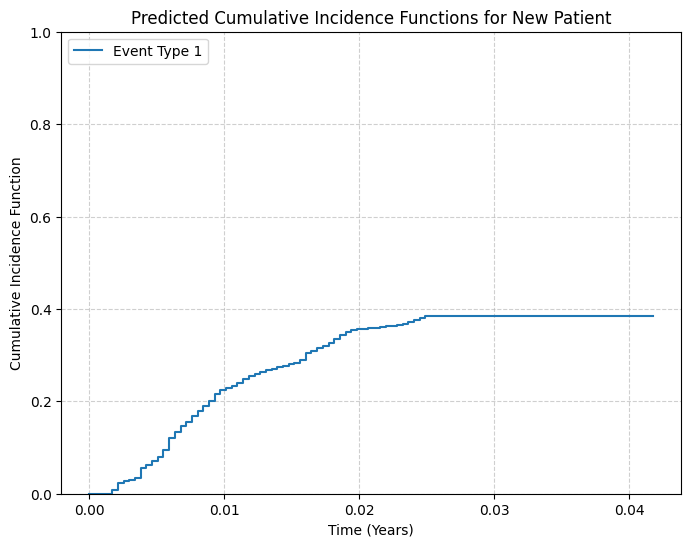

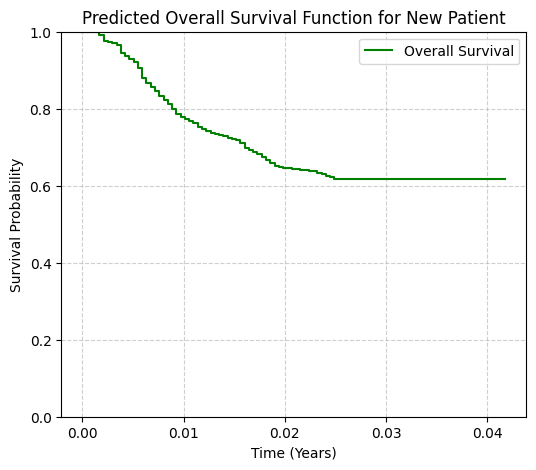


Calculating Competing Risks Evaluation Metrics (using training data for demonstration):
Predicting CIFs for all individuals in data_cr for evaluation metrics...

Competing Risks C-index for Event Type 1 (Melanoma Death): 0.5896

Competing Risks Brier Scores for Event Type 1 (Melanoma Death) at times 0.0000 and 0.0418: 0.0000 and 0.1101
Integrated Brier Score (IBS) for Event Type 1: 0.0059


In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Set a random seed for reproducibility
np.random.seed(123)

# Assuming 'data_cr' DataFrame is already loaded and preprocessed from previous steps
# Assuming 'build_survival_tree_cr', 'predict_tree_cr', 'predict_rsf_cr',
# 'competing_risks_split_criterion', and 'plot_cifs' functions are already defined.

# 2. Build the Competing Risks Random Survival Forest
# Need to build multiple trees and store them
n_trees = 10 # Reduced number of trees for quicker demonstration
max_depth = 3
min_node_size = 5

trees_cr = []
print(f"Building Competing Risks Random Survival Forest with {n_trees} trees...")
for i in range(n_trees):
    # Use bootstrap_sample to get a sample for each tree
    # Note: bootstrap_sample might need adaptation for competing risks if specific sampling
    # strategies are desired, but for now, standard bootstrap on indices is used.
    # Ensure data_cr is used, not data
    bootstrap_data = data_cr.sample(frac=1, replace=True).reset_index(drop=True)

    # Build a single tree
    tree = build_survival_tree_cr(bootstrap_data, max_depth, min_node_size)
    trees_cr.append(tree)
    print(f"Built tree {i+1}/{n_trees}")

print("Competing Risks Random Survival Forest built.")


# 3. Create a pandas Series representing a new patient's data
# Ensure the features match the data_cr columns used in the trees (excluding time and event_type)
new_patient_data_cr = {'age': 50, 'sex': 1, 'thickness': 2.5, 'ulcer': 1}
new_patient_cr = pd.Series(new_patient_data_cr)

# 4. Define an array of time points for prediction
# Use a range of times relevant to the data
times_cr = np.linspace(0, data_cr['time'].max(), 100) # Predict over the observed time range

# 5. Predict the CIFs for the new patient
prediction_cr = predict_rsf_cr(trees_cr, new_patient_cr, times_cr)

# 6. Print the predicted CIFs (optional, for inspection)
print("\nPredicted CIFs for new patient:")
cifs_df = pd.DataFrame({'Time': prediction_cr['times']})
for event_type, cif_values in prediction_cr['cifs'].items():
    cifs_df[f'CIF Event {event_type}'] = cif_values
display(cifs_df.head()) # Display first few rows
display(cifs_df.tail()) # Display last few rows


# 7. Plot the CIFs
plot_cifs(prediction_cr['cifs'], prediction_cr['times'], title="Predicted Cumulative Incidence Functions for New Patient")

# Optionally, plot overall survival
plt.figure(figsize=(6, 5))
plt.step(prediction_cr['times'], prediction_cr['overall_survival'], where='post', label='Overall Survival', color='green')
plt.title("Predicted Overall Survival Function for New Patient")
plt.xlabel("Time (Years)")
plt.ylabel("Survival Probability")
plt.legend(loc="upper right")
plt.ylim(0, 1)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


# Example of using evaluation metrics (assuming you have data for evaluation)
# For demonstration, let's use the entire data_cr as if it were test data
# In a real scenario, you would split your data into training and testing sets.

# Make predictions for all individuals in data_cr for evaluation metrics
# This can be computationally intensive for large datasets and many trees
# Let's select a subset for demonstration or skip if too slow.
print("\nCalculating Competing Risks Evaluation Metrics (using training data for demonstration):")

try:
    # Predict CIFs for all individuals in the data_cr for evaluation
    # This might take time depending on the number of individuals and trees
    print("Predicting CIFs for all individuals in data_cr for evaluation metrics...")
    predicted_cifs_all_individuals = {}
    all_event_types_in_data = sorted(data_cr['event_type'].unique())
    all_event_types_in_data = [et for et in all_event_types_in_data if et > 0]

    predicted_cifs_individual_lists = {et: [] for et in all_event_types_in_data}

    for index, row in data_cr.iterrows():
        # Select features for prediction
        row_features = row[['age', 'sex', 'thickness', 'ulcer']]
        prediction_cr_eval = predict_rsf_cr(trees_cr, row_features, times_cr)
        for et in all_event_types_in_data:
            if et in prediction_cr_eval['cifs']:
                predicted_cifs_individual_lists[et].append(prediction_cr_eval['cifs'][et])
            else:
                # If event type not predicted for this individual/tree path, append zeros
                predicted_cifs_individual_lists[et].append(np.zeros_like(times_cr).tolist())

    # Stack the lists into numpy arrays (n_individuals, n_times)
    predicted_cifs_stacked = {et: np.array(predicted_cifs_individual_lists[et]) for et in all_event_types_in_data}

    actual_event_times = data_cr['time'].values
    actual_event_types = data_cr['event_type'].values

    # Calculate Competing Risks C-index for event type 1 (death from melanoma)
    # Using predicted CIF at the maximum time point as risk score
    max_time_index = len(times_cr) - 1
    if 1 in predicted_cifs_stacked and max_time_index < predicted_cifs_stacked[1].shape[1]:
        predicted_risks_for_c_index = predicted_cifs_stacked[1][:, max_time_index]
        cr_c_index_melanoma = concordance_index_competing_risks(actual_event_times, actual_event_types, predicted_risks_for_c_index, event_of_interest=1)
        print(f"\nCompeting Risks C-index for Event Type 1 (Melanoma Death): {cr_c_index_melanoma:.4f}")
    else:
        print("\nCannot compute Competing Risks C-index for Event Type 1 (Melanoma Death).")


    # Calculate Competing Risks Brier Score for event type 1 (death from melanoma)
    if 1 in predicted_cifs_stacked:
        brier_times_cr, brier_scores_cr, ibs_cr = brier_score_competing_risks(actual_event_times, actual_event_types, predicted_cifs_stacked, times_cr, event_of_interest=1)

        if not np.all(np.isnan(brier_scores_cr)):
             # Fix: Format each element of the array individually
             print(f"\nCompeting Risks Brier Scores for Event Type 1 (Melanoma Death) at times {brier_times_cr[0]:.4f} and {brier_times_cr[-1]:.4f}: {brier_scores_cr[0]:.4f} and {brier_scores_cr[-1]:.4f}") # Print first and last Brier score
             print(f"Integrated Brier Score (IBS) for Event Type 1: {ibs_cr:.4f}")
        else:
             print("\nCannot compute Competing Risks Brier Scores or IBS for Event Type 1 (Melanoma Death).")
    else:
         print("\nCannot compute Competing Risks Brier Scores or IBS for Event Type 1 (Melanoma Death).")


except Exception as e:
    print(f"\nAn error occurred during evaluation metrics calculation: {e}")

## Summary and Conclusion

This notebook explores Random Survival Forests (RSF) in Python. It first builds an RSF from scratch to show the mechanics (bootstrapping, log-rank splitting, Nelson-Aalen CHF). Then, it demonstrates using the scikit-survival library for standard RSF tasks, including fitting, C-index, Brier score, CRPS, and variable importance. Finally, it introduces competing risks and provides a custom implementation for handling multiple event types, including a competing risks split criterion, CSCHF/CIF calculation, and relevant evaluation metrics.

## References


1. Ishwaran, H., et al. (2008). Random survival forests. *The Annals of Applied Statistics*, 2(3), 841–860. DOI: 10.1214/08-AOAS169.
2. Pölsterl, S. (2020). scikit-survival: A Library for Time-to-Event Analysis. *JMLR*, 21(207), 1–6. http://jmlr.org/papers/v21/20-008.html.
3. Gerds, T. A., & Schumacher, M. (2006). Consistent Estimation of the Expected Brier Score. *Biometrical Journal*, 48(6), 1029–1040. DOI: 10.1002/bimj.200610301.
4. Gneiting, T., & Raftery, A. E. (2007). Strictly Proper Scoring Rules. *JASA*, 102(477), 359–378. DOI: 10.1198/016214506000001437.
5. scikit-survival Documentation. https://scikit-survival.readthedocs.io/en/stable/.